# Multi view SUN

In [1]:
from tqdm import tqdm
from util import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
import pandas as pd
import copy
from PIL import Image
%matplotlib inline

In [2]:
tr = pd.read_csv('./combine_txt/sun397_train_lt.txt', header=None, sep=' ')

class_names = {}
class_num = {}

for lab in tr[1].unique():
    temp = tr.loc[tr[1] == lab].iloc[0, 0]
    
    if 'indoor' in temp or 'outdoor' in temp:
        class_name = temp.split('/')[-3] + '/' + temp.split('/')[-2]
        class_names[lab] = class_name
        class_num[lab] = len(tr.loc[tr[1] == lab])
    else:
        class_name = temp.split('/')[-2]
        class_names[lab] = class_name
        class_num[lab] = len(tr.loc[tr[1] == lab])

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
#  device = torch.device('cpu')

In [5]:
LOG_DIR = './log'
DATASET = 'plain'
MODEL_ID = 'test'
DATALOADER_WORKERS = 4
LEARNING_RATE = 0.01
LR_DECAY_FACTOR = 0.1
LR_DECAY_EPOCHS = 10
DROPOUT = True
DROPOUT_RATE = 0.5
MOMENTUM = 0.9
EPOCHS = 1
BATCH_SIZE = 64
DISPLAY_STEP = 10
NUM_CLASSES = 397
MULTI_VIEW_NUMBER = 5

if not os.path.isdir(LOG_DIR):
    os.makedirs(LOG_DIR)

In [6]:
class sun_dataset_test (torch.utils.data.Dataset):
    
    def __init__ (self, txt_file, multi_view_time, transform):
        super().__init__()
        self.df = pd.read_csv(txt_file, header=None, sep=' ')
        self.transform = transform
        self.multi_view_time = multi_view_time
        
    def __len__ (self):
        return len(self.df)
    
    def __getitem__ (self, idx):
        
        image = Image.open(self.df.iloc[idx, 0])
        label = self.df.iloc[idx, 1] - 1
        
        mult_view_images = torch.tensor([], dtype=torch.float32)

        for i in range(self.multi_view_time):
            image_transform = self.transform(image).unsqueeze(0)
            mult_view_images = torch.cat((mult_view_images, image_transform), 0)
            
        return mult_view_images, label

In [7]:
# transforms.RandomResizeCrop(224)
data_transform = transforms.Compose([
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [8]:
dataset = sun_dataset_test(txt_file='./sun397_test_lt.txt', transform=data_transform, multi_view_time=MULTI_VIEW_NUMBER)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=DATALOADER_WORKERS)
dataset_size = len(dataset)

In [9]:
# j = i.reshape((-1, i.shape[2], i.shape[3], i.shape[4]))

# def imshow(inp, title=None):
#     """Imshow for Tensor."""
#     inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
#     plt.imshow(inp)
#     if title is not None:
#         plt.title(title)

# img_grid = torchvision.utils.make_grid(j[0:5])

# imshow(img_grid)

In [14]:
checkpoint = torch.load('./log/epoch_save_50/epoch_34_checkpoint.pth.tar')
DROPOUT = True
DROPOUT_RATE = 0.5
FC_ADD_DIM = 4096
BIAS = True

In [15]:
# resnet = torchvision.models.resnet152(pretrained=False)
# # Freeze all layers
# for param in resnet.parameters():
#     param.requires_grad = False

resnet = torchvision.models.resnet50(pretrained=False)

print('Done.')    

if DROPOUT:
    print('Model using dropout.')
    resnet = MyResNet(resnet, NUM_CLASSES, DROPOUT_RATE, FC_ADD_DIM, bias=BIAS)
else:
    print('Model not using dropout.')
    # Reset the fc layer
    num_features = resnet.fc.in_features
    resnet.fc = nn.Linear(num_features, NUM_CLASSES)

# Remember to comment this out
resnet = nn.DataParallel(resnet)
    
resnet = resnet.to(device)

loss_function = nn.CrossEntropyLoss()

Done.
Model using dropout.
Bias is True
Intermediate fc dimension is: 4096
Dropout rate is: 0.500000


In [16]:
model = resnet

model.eval()

model.load_state_dict(checkpoint)

In [17]:
running_correct_total = 0

class_correct = torch.tensor([0. for i in range(NUM_CLASSES)])
class_total = torch.tensor([0. for i in range(NUM_CLASSES)])

# Iterate over data
for inputs, labels in tqdm(dataloader):
    
    # Reshape inputs into a 4D tensor
    inputs = inputs.reshape((-1, inputs.shape[2], inputs.shape[3], inputs.shape[4]))

    # To device
    inputs, labels = inputs.to(device), labels.to(device)

    # Forward
    # If on training phase, enable gradients
    with torch.set_grad_enabled(False):

        logits = model(inputs)
        
        # Adding multiview dimension into logits
        logits = logits.reshape((-1, MULTI_VIEW_NUMBER, NUM_CLASSES))
        
        # Mean over multiview dimension
        logits = logits.mean(dim=1)
        
        _, preds = torch.max(logits, 1)
    
    # Record correct predictions
    correct_tensor = (preds == labels).squeeze()
    running_correct_total += correct_tensor.sum().item()

    for i in range(len(labels)):
        label = labels[i]
        class_correct[label] += correct_tensor[i].item()
        class_total[label] += 1

        
test_acc_mic = running_correct_total / dataset_size
test_acc_mac = (class_correct / class_total).mean().item()

print('accuracy_micro: %.3f, accuracy_macro: %.3f' 
      % (test_acc_mic, test_acc_mac))
    

100%|██████████| 249/249 [02:25<00:00,  1.72it/s]

accuracy_micro: 0.527, accuracy_macro: 0.527


resnet 34 52.7

In [18]:
class_acc = class_correct / class_total

for l in range(len(class_acc)):
    print('class id: %4d,    class name: %25s,    class data number: %5d,    accuracy: %.1f' %(l, class_names[l+1], class_num[l+1], class_acc[l]*100))

class id:    0,    class name:                     abbey,    class data number:   232,    accuracy: 42.5
class id:    1,    class name:            airplane_cabin,    class data number:    12,    accuracy: 32.5
class id:    2,    class name:          airport_terminal,    class data number:   597,    accuracy: 77.5
class id:    3,    class name:                     alley,    class data number:   136,    accuracy: 75.0
class id:    4,    class name:              amphitheater,    class data number:   132,    accuracy: 70.0
class id:    5,    class name:          amusement_arcade,    class data number:    74,    accuracy: 60.0
class id:    6,    class name:            amusement_park,    class data number:   392,    accuracy: 72.5
class id:    7,    class name:          anechoic_chamber,    class data number:    46,    accuracy: 70.0
class id:    8,    class name: apartment_building/outdoor,    class data number:   259,    accuracy: 47.5
class id:    9,    class name:               apse/indo

In [31]:
a = Image.open('/home/public/dataset/SUN397/c/control_room/sun_afzwbxzzmsxvwwip.jpg')

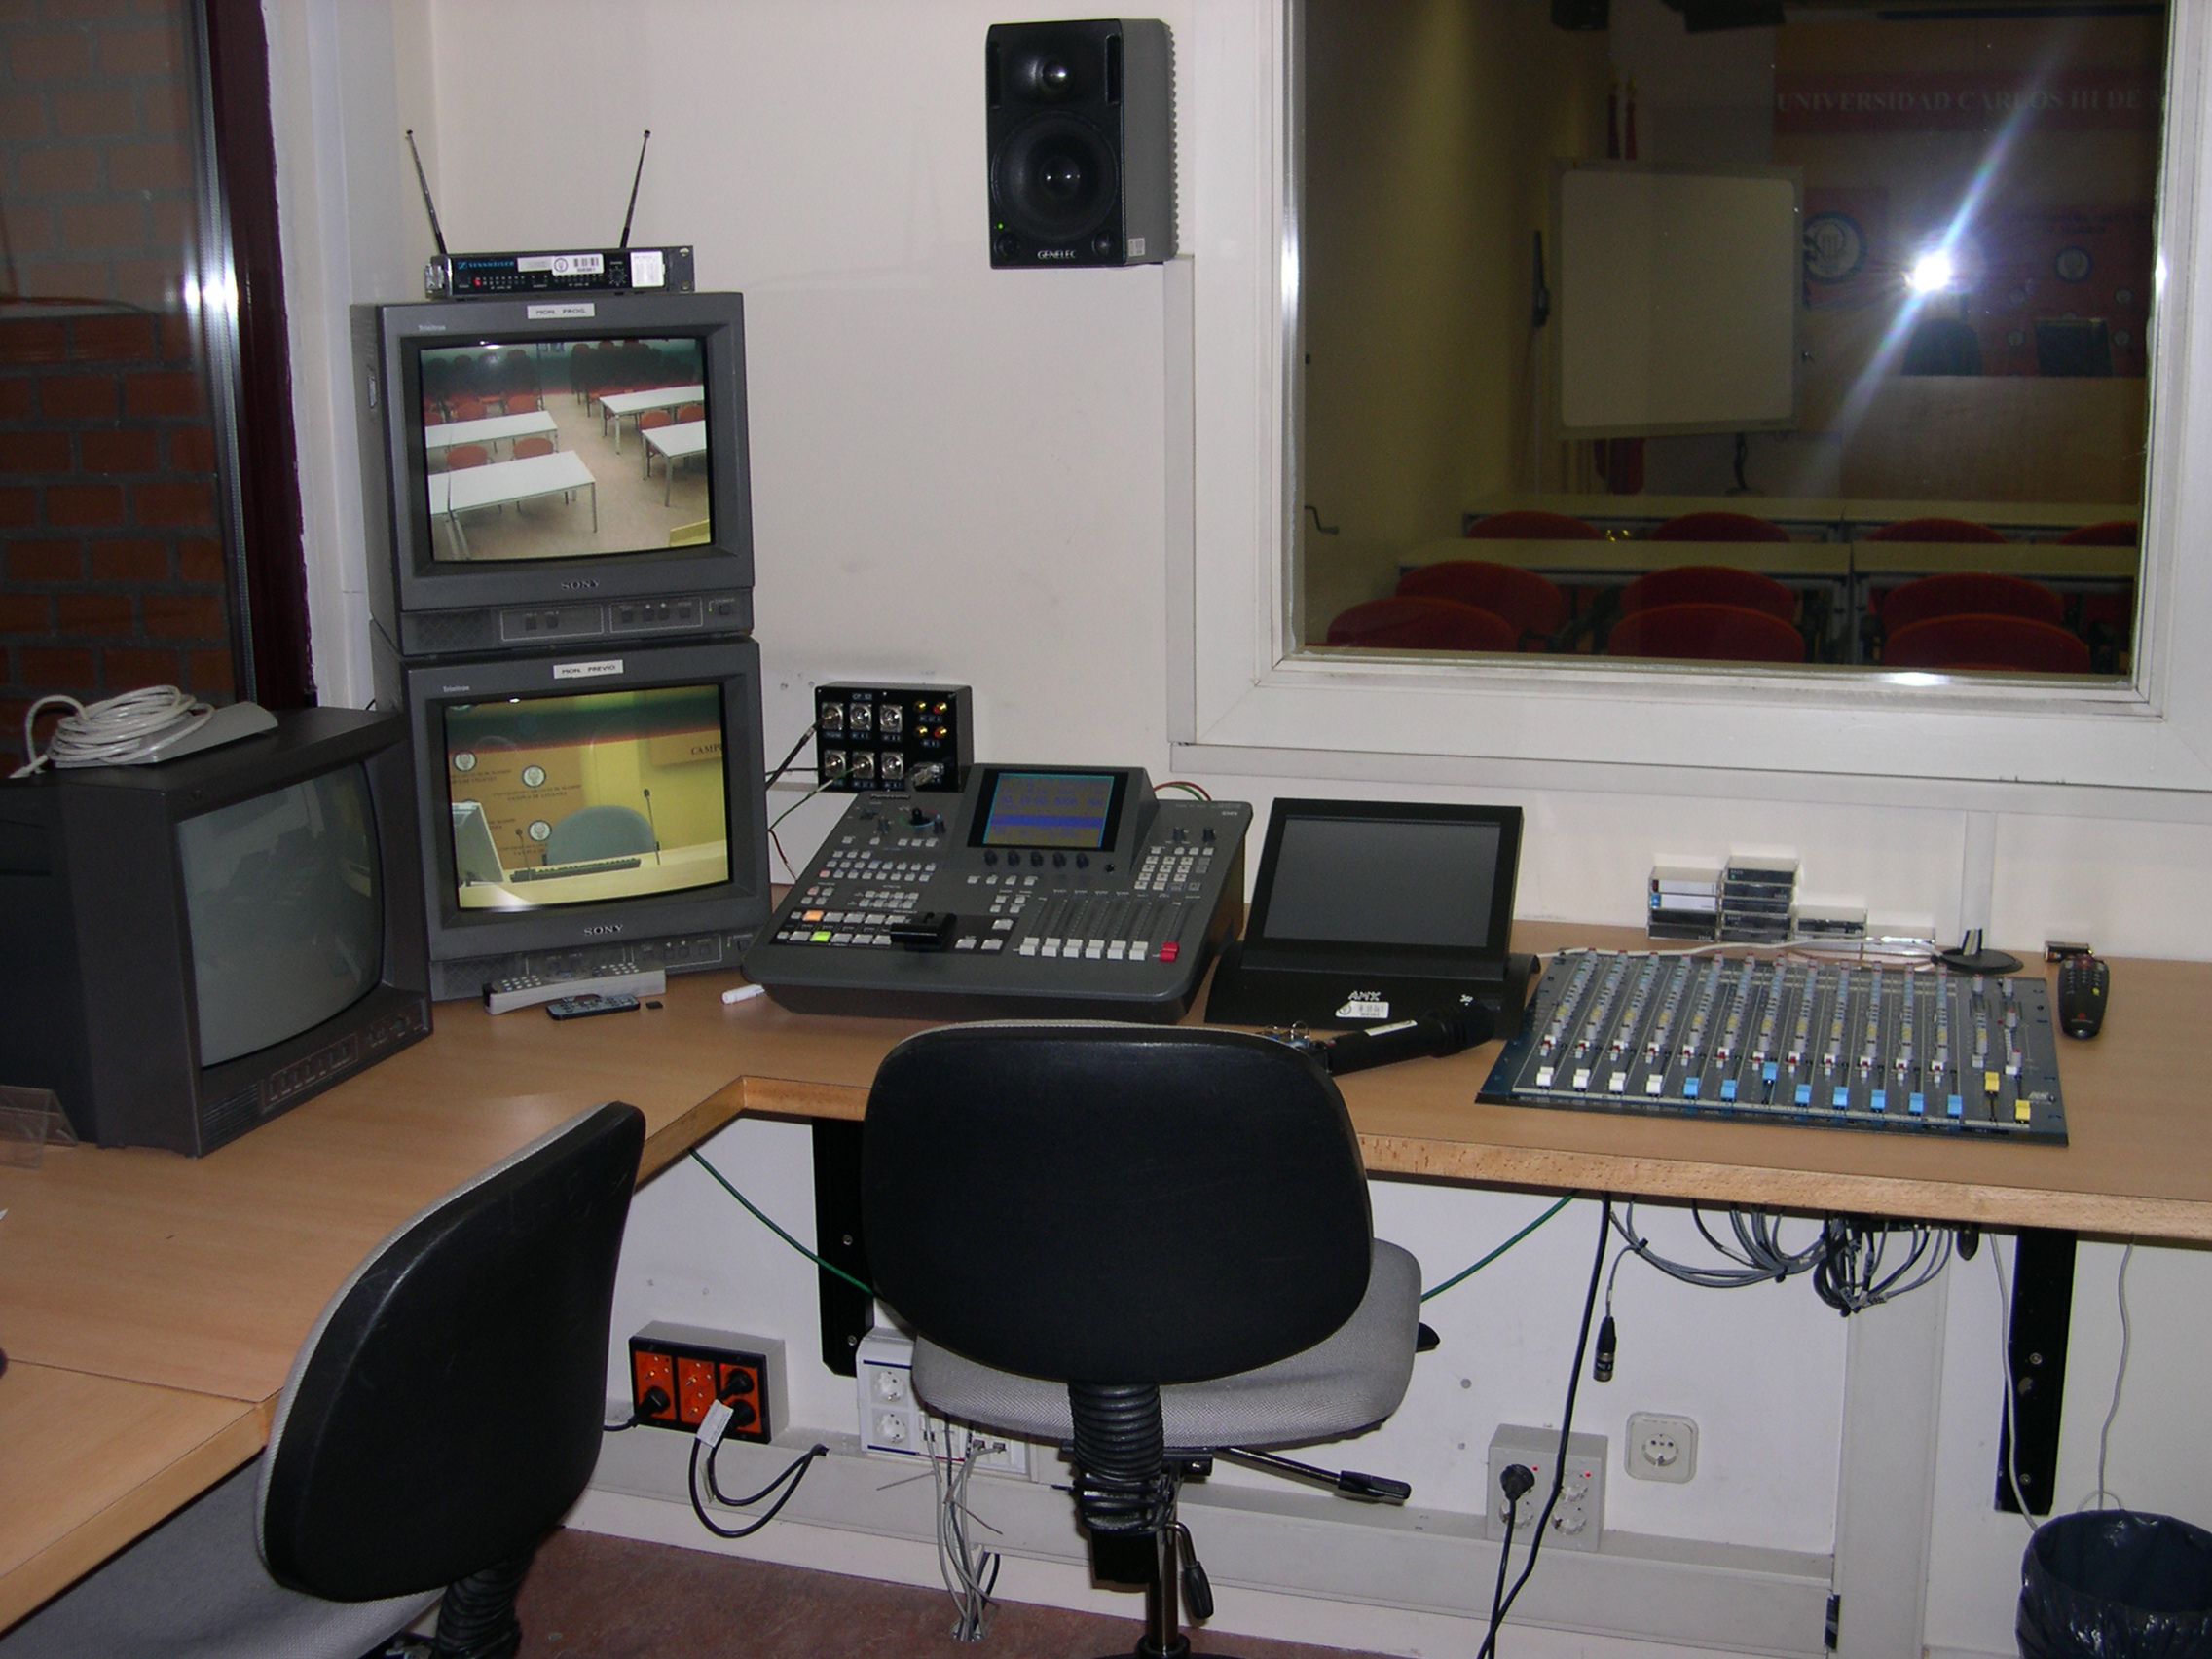

In [32]:
a